In [1]:
import wikipediaapi
import requests
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

# Step 1: Crawl a real-world dataset

## Data Source:
The data was sourced from Wikipedia using the `requests` library and the `wikipediaapi`. 

## Variables of Interest:
I mainly focused on 

In [2]:
class WikiDataCrawl:
    def __init__(self):
        self.__user_agent = "Wikipedia_Data_Analytics (nv22224@bristol.ac.uk)"
        self.__titles = []
        self.__wiki_data = pd.DataFrame(columns=['Title','Sumary', 'Sumary Length','Sumary Word Count','Sections Length',
                                                 'Text Length', 'Word Count',
                                                 'Language Count', 'Pageviews'])
        
    def get_wikipedia_page_info(self, title: str):
        # Create a Wikipedia API object
        wiki_wiki = wikipediaapi.Wikipedia(self.__user_agent, 'en')

        # Obtain a page object
        page = wiki_wiki.page(title)

        if not page.exists():
            return None

        # Obtain the length and word count of the page
        page_length = len(page.text)
        page_word_count = len(page.text.split())

        # Construct an API URL to retrieve Wikipedia page information
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&titles={title}&prop=info|pageviews"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the language count of the page 
        langlinks = page.langlinks
        language_count = len(langlinks)

        try:
            # Obtain the page views
            page_info = data["query"]["pages"]
            page_id = list(page_info.keys())[0]
            pageviews = page_info[page_id]["pageviews"]
            
        except KeyError:
            return None


        # Create a dictionary for storing page information.
        page_data = {
            "Title": page.title,
            "Sumary": page.summary[:100],
            "Sumary Length": len(page.summary),
            "Sumary Word Count": len(page.summary.split()),
            "Sections Length": len(page.sections),
            "Text Length": page_length,
            "Word Count": page_word_count,
            "Language Count": language_count + 1, # English page itself should be included
            "Pageviews": pageviews
        }
        return page_data
    
    def get_random_wikipedia_titles(self, title_nums=150):
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&list=random&rnnamespace=0&rnlimit={title_nums}"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the title list
        self.__titles = [page['title'] for page in data['query']['random']]

        return self.__titles 
    
    def __call__(self, title_nums):
        
        title_list = self.get_random_wikipedia_titles(title_nums) 
        
        for title in title_list:
            page_data = self.get_wikipedia_page_info(title)
            if page_data is not None:
                self.__wiki_data.loc[len(self.__wiki_data)] = page_data
        
        return self.__wiki_data

In [3]:
# wiki_data_crawl = WikiDataCrawl()
# wiki_data = wiki_data_crawl(600)
# wiki_data.to_csv('wiki_data.csv', index=False)

# Step 2: Perform data preparation & cleaning

In [4]:
wiki_data = pd.read_csv("wiki_data.csv")
wiki_data.rename(columns={"Sumary": "Summary", "Sumary Length": "Summary Length",
                          "Sumary Word Count": "Summary Word Count"}, inplace=True)

## Check whether the dataset has any missing value

In [5]:
display(wiki_data.head(10))
print("===========================================================================================================")
print(f"wiki_data's shape is {wiki_data.shape}")
print("===========================================================================================================")
display(wiki_data.info())

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Pageviews
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,"{'2023-10-26': None, '2023-10-27': 1, '2023-10..."
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,"{'2023-10-26': 4, '2023-10-27': 6, '2023-10-28..."
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,"{'2023-10-26': 3, '2023-10-27': 1, '2023-10-28..."
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,"{'2023-10-26': 22, '2023-10-27': 35, '2023-10-..."
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,"{'2023-10-26': 58, '2023-10-27': 43, '2023-10-..."
5,City Lights,City Lights is a 1931 American silent romantic...,1805,292,8,27890,4750,53,"{'2023-10-26': 428, '2023-10-27': 506, '2023-1..."
6,Eliza A. Dupuy,"Eliza Ann Dupuy (c. 1814 – December 29, 1880) ...",895,149,5,6433,1037,1,"{'2023-10-26': 0, '2023-10-27': 1, '2023-10-28..."
7,El-Gendi Fortress,The El-Gendi Fortress (Arabic: قلعة الجندي) is...,458,67,3,680,100,6,"{'2023-10-26': 3, '2023-10-27': 20, '2023-10-2..."
8,Bądzsław,Bądzsław [ˈbɔ̃tswaf] is a masculine Old Polish...,196,34,0,196,34,2,"{'2023-10-26': None, '2023-10-27': 0, '2023-10..."
9,Acceptance discography,"The discography of Acceptance, an American alt...",135,20,2,199,29,1,"{'2023-10-26': 4, '2023-10-27': 2, '2023-10-28..."


wiki_data's shape is (499, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               499 non-null    object
 1   Summary             499 non-null    object
 2   Summary Length      499 non-null    int64 
 3   Summary Word Count  499 non-null    int64 
 4   Sections Length     499 non-null    int64 
 5   Text Length         499 non-null    int64 
 6   Word Count          499 non-null    int64 
 7   Language Count      499 non-null    int64 
 8   Pageviews           499 non-null    object
dtypes: int64(6), object(3)
memory usage: 35.2+ KB


None

In [6]:
wiki_data["Pageviews"] = wiki_data["Pageviews"].apply(lambda x: eval(x))

## Create new features

In [7]:
def dict_average(dictionary: dict):
    # Check if dictionary is null
    if dictionary is None:
        return None  

    # Filter null value
    valid_values = [value for value in dictionary.values() if value is not None]
    
    # Check if all values are null
    if valid_values is None:
        return None  

    # Calculate the average
    average = round((sum(valid_values) / len(valid_values)))
    return average

def dict_max(dictionary: dict):
    
    value_set = set()
    
    for value in dictionary.values():
        if value is not None:
            value_set.add(value)
            
    if value_set is not None:
        return max(value_set)
    else:
        return None

wiki_data["Average Pageviews"] = wiki_data["Pageviews"].apply(dict_average)
wiki_data["Max Pageviews"] = wiki_data["Pageviews"].apply(dict_max)

In [8]:
wiki_data.drop(columns=["Pageviews"],axis=1,inplace=True)
wiki_data["Summary Content Ratio(%)"] = round(wiki_data["Summary Word Count"]/wiki_data["Word Count"] * 100, 2)

In [9]:
wiki_data["Only Summary"] = wiki_data["Summary Content Ratio(%)"].apply(lambda x: 1 if x==100.00 else 0) # If the page only has summary

In [10]:
wiki_data.head()

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%),Only Summary
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,1,4,100.00,1
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,7,19,9.75,0
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,3,11,18.75,0
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,172,4317,20.27,0
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,45,96,5.02,0


## Step 3: Perform exploratory analysis

In [11]:
numerical_columns = ['Summary Length', 'Summary Word Count',
       'Sections Length', 'Text Length', 'Word Count', 'Language Count',
       'Average Pageviews', 'Max Pageviews', 'Summary Content Ratio(%)']
wiki_data_numerical = wiki_data.loc[:,numerical_columns]

In [12]:
wiki_data_numerical_statistics = wiki_data_numerical.describe().T
sum_column = pd.Series(wiki_data_numerical.sum(), name="sum")
wiki_data_numerical_statistics = pd.concat([wiki_data_numerical_statistics, sum_column], axis=1)
wiki_data_numerical_statistics["count"] = wiki_data_numerical_statistics["count"].astype(int)
wiki_data_numerical_statistics["mean"] = wiki_data_numerical_statistics["mean"].apply(lambda x: round(x, 2))
wiki_data_numerical_statistics["std"] = wiki_data_numerical_statistics["std"].apply(lambda x: round(x, 2))
display(wiki_data_numerical_statistics)

,count,mean,std,min,25%,50%,75%,max,sum
Summary Length,499,479.29,509.44,17.00,175.50,311.00,548.50,4251.0,239165.00
Summary Word Count,499,76.66,79.72,4.00,28.00,50.00,88.00,684.0,38253.00
Sections Length,499,3.59,3.24,0.00,1.00,3.00,5.00,28.0,1791.00
Text Length,499,3198.59,5501.65,70.00,444.50,1190.00,3378.50,46962.0,1596094.00
Word Count,499,507.35,858.47,11.00,70.50,195.00,522.00,6988.0,253168.00
Language Count,499,5.98,9.45,1.00,1.00,3.00,7.00,130.0,2985.00
Average Pageviews,499,43.31,319.97,0.00,1.00,2.00,9.00,6360.0,21612.00
Max Pageviews,499,128.68,766.06,0.00,3.00,9.00,26.50,13252.0,64210.00
Summary Content Ratio(%),499,44.94,37.44,0.29,9.43,30.64,87.94,100.0,22427.04


In [13]:
wiki_data_numerical

,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%)
0,1725,267,0,1725,267,4,1,4,100.00
1,397,73,8,4439,749,1,7,19,9.75
2,246,42,6,1332,224,3,3,11,18.75
3,719,105,4,3869,518,28,172,4317,20.27
4,548,96,11,11283,1913,11,45,96,5.02
...,...,...,...,...,...,...,...,...,...
494,153,25,2,2885,460,6,1,6,5.43
495,920,141,4,1337,205,1,2,6,68.78
496,178,29,4,2550,414,3,90,182,7.00
497,94,17,6,4114,710,2,4,38,2.39


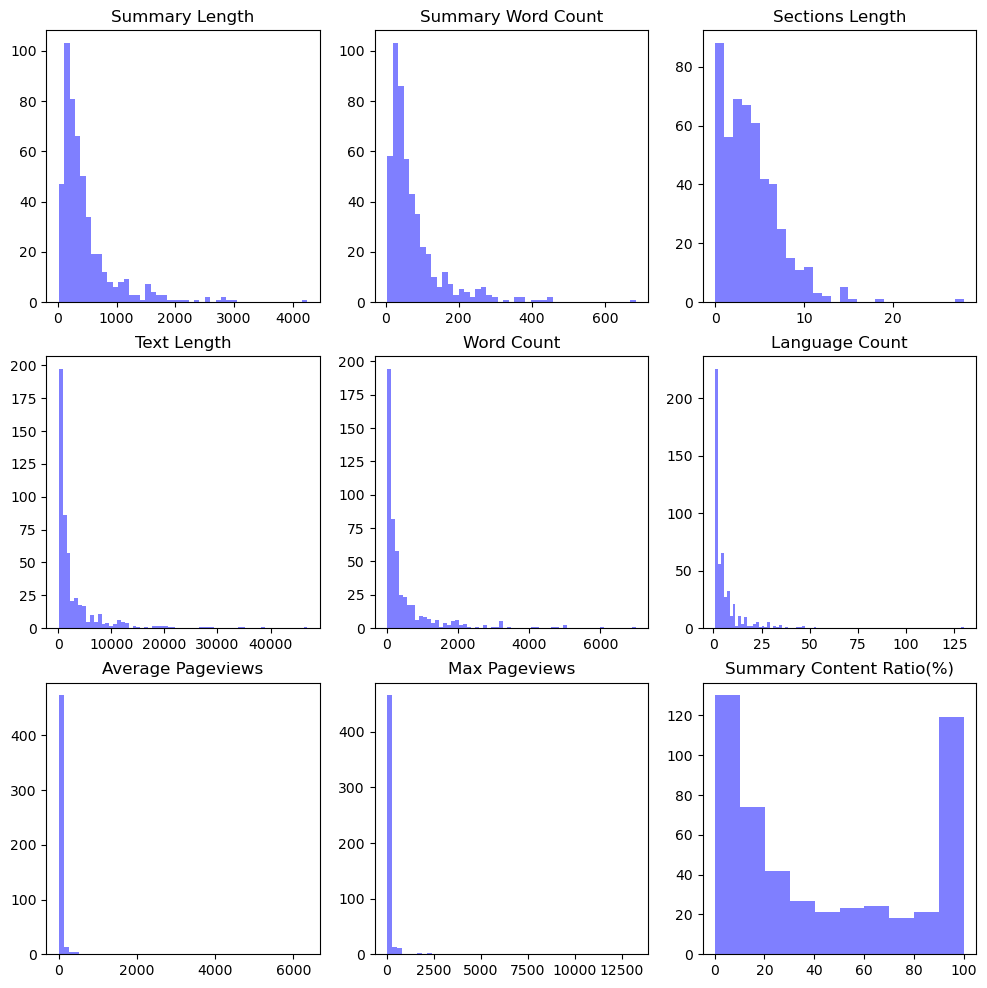

In [14]:
index = 0
wiki_data_numerical_columns = list(wiki_data_numerical.columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for i in range(3):
    for j in range(3):
        title = wiki_data_numerical_columns[index]
        
        data = wiki_data_numerical[title]
        
        if "Pageviews" not in title:
            axes[i, j].hist(x=data, bins='auto', color='blue', alpha=0.5)
        else:
            axes[i, j].hist(x=data, bins=50, color='blue', alpha=0.5)
        axes[i, j].set_title(f"{title}")
        index += 1

Text(0, 0.5, 'Summary Length')

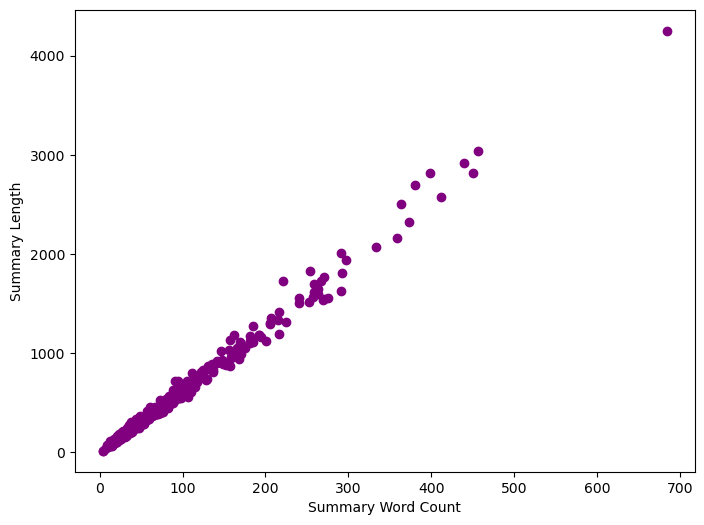

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Summary Word Count"]
y = wiki_data_numerical["Summary Length"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Summary Word Count")
ax.set_ylabel("Summary Length")

Text(0, 0.5, 'Language Count')

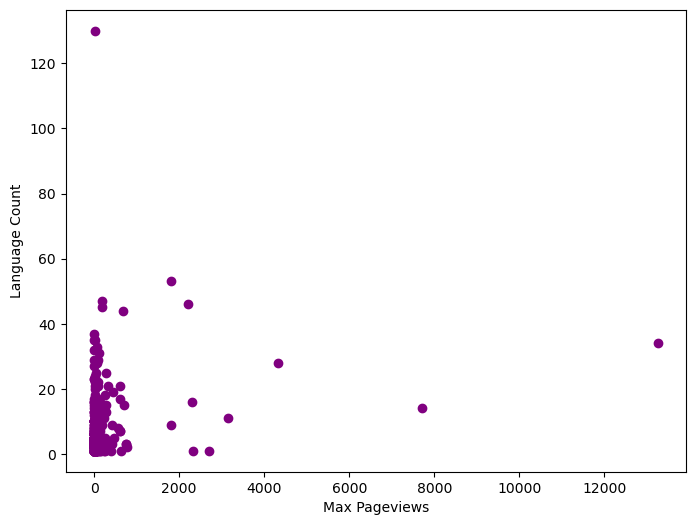

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Max Pageviews"]
y = wiki_data_numerical["Language Count"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Max Pageviews")
ax.set_ylabel("Language Count")

Text(0, 0.5, 'Max Pageviews')

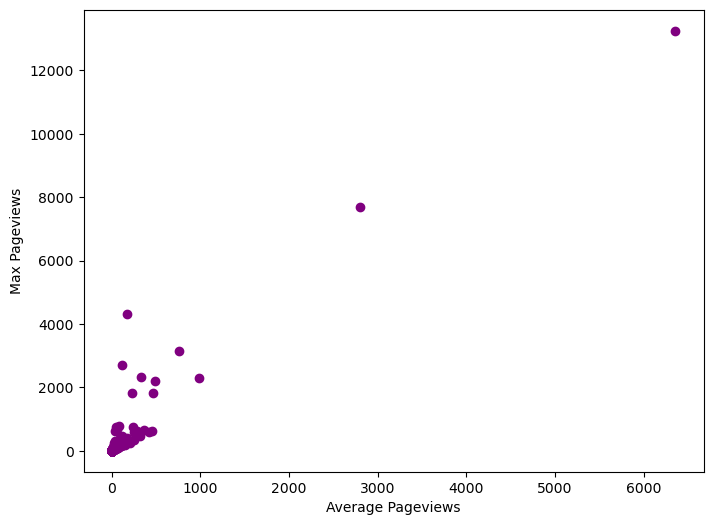

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Average Pageviews"]
y = wiki_data_numerical["Max Pageviews"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Average Pageviews")
ax.set_ylabel("Max Pageviews")

Text(0, 0.5, 'Word Count')

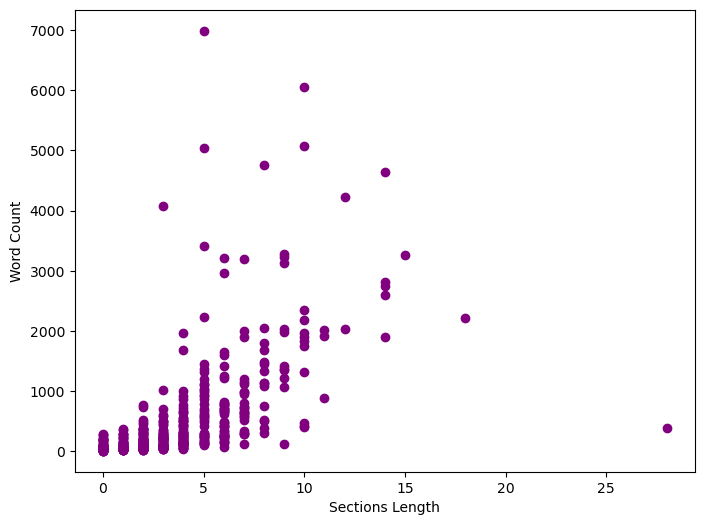

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Sections Length"]
y = wiki_data_numerical["Word Count"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Sections Length")
ax.set_ylabel("Word Count")

In [19]:
wiki_data_numerical.columns

Index(['Summary Length', 'Summary Word Count', 'Sections Length',
       'Text Length', 'Word Count', 'Language Count', 'Average Pageviews',
       'Max Pageviews', 'Summary Content Ratio(%)'],
      dtype='object')

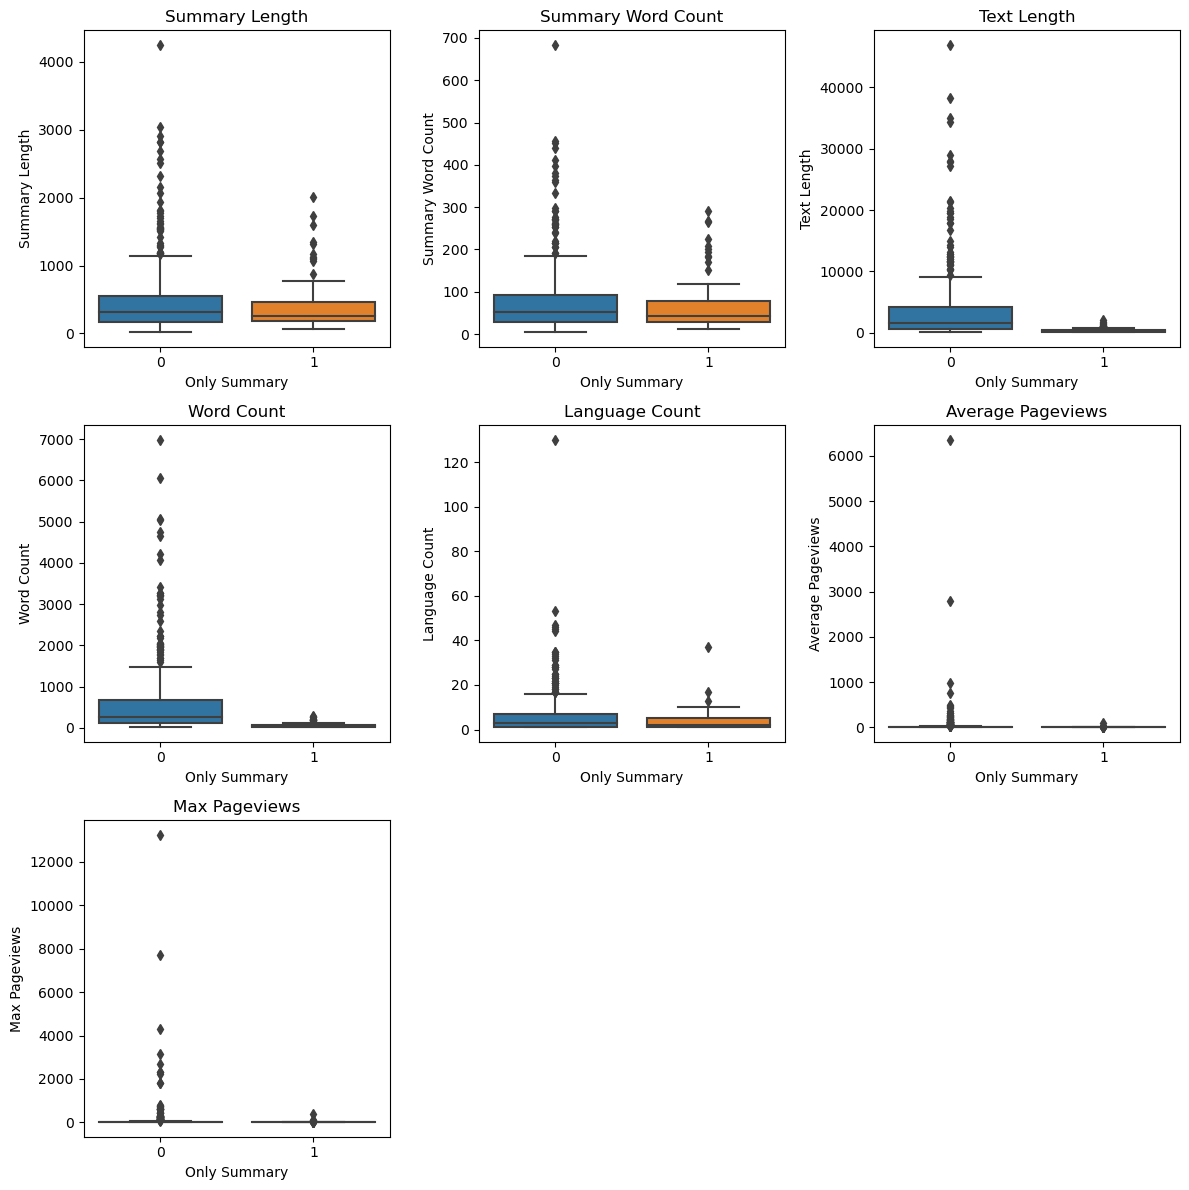

In [20]:
columns = [col for col in wiki_data_numerical.columns if col not in ["Sections Length", "Summary Content Ratio(%)"]]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.boxplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
axes.flatten()[7].set_visible(False)
axes.flatten()[8].set_visible(False)
    
plt.tight_layout()
plt.show()

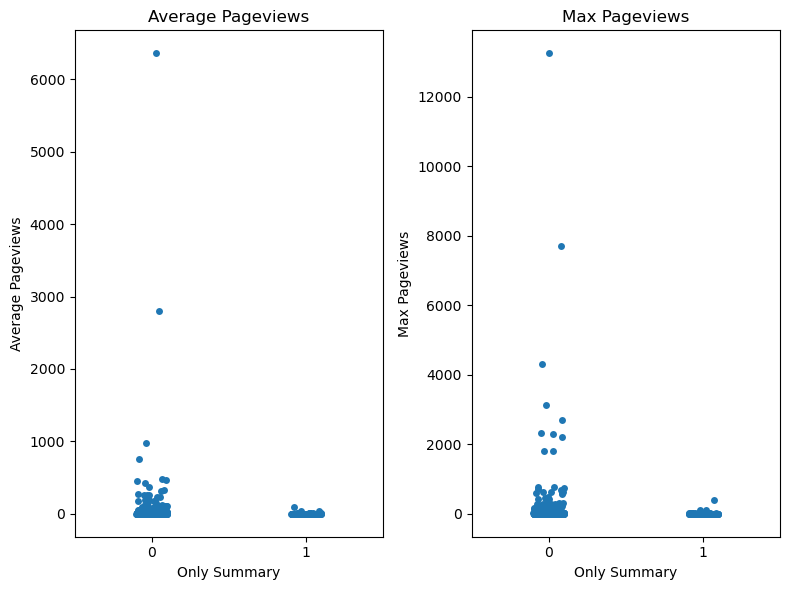

In [21]:
columns = ['Average Pageviews', 'Max Pageviews']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.stripplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
plt.tight_layout()
plt.show()

# Step 4: Ask questions

## Question a: Is there a linear relationship between `Word Count` and `Text Length`? 

In [22]:
x = wiki_data_numerical.loc[:,"Word Count"].to_numpy()
y = wiki_data_numerical.loc[:,"Text Length"].to_numpy()

### Hypothesis Testing:

1. Supposed that $\rho$ represents the population correlation coefficient, The null hypothesis $H_0$ and alternative hypothesis $H_1$ for this test are as follows:
$$H_0: \rho = 0 \\$$
$$H_1: \rho \neq 0$$

2. This test is based on the sample data's calculated correlation coefficient, using the t-statistic to assess whether the sample correlation coefficient is significantly different from zero. The formula for the t-statistic is:
$$t = \frac{r\sqrt[2]{n-2}}{1-r^2} \sim t(n-2)$$
where $r$ reprensts the the sample correlation coefficient and $n$ is the sample size.

3. Set $\alpha = 0.05$ and caculate the `p` value.

In [23]:
pc = pearsonr(x,y)[0]
print(f"Pearson correlation coefficient is {pc}.")

Pearson correlation coefficient is 0.9982001382921664.


In [24]:
p_value = pearsonr(x,y)[1]
print(f"p_value is {p_value:.2f}")

p_value is 0.00


 $p < \alpha$, therefore, $H_0$ should be rejected and that means there is a linear relationship between `Word Count` and `Text Length`.

## Question b: Can we predict whether a Wikipedia article only has summary section based on `Word Count`, `Language Count` and `Average Pageviews`? 

In [25]:
from sklearn.model_selection import train_test_split

Only Summary
0    411
1     88
Name: count, dtype: int64

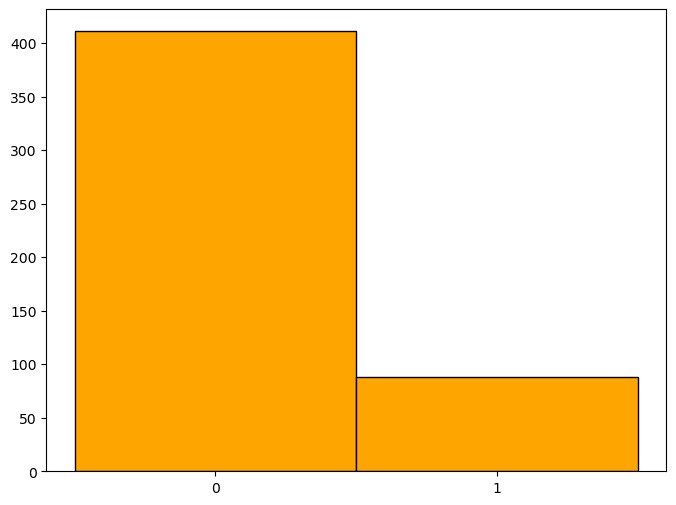

In [26]:
X = wiki_data.loc[:,["Word Count","Language Count","Average Pageviews"]]
y = wiki_data.loc[:,"Only Summary"]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(y,bins=[-0.5, 0.5, 1.5], align="mid",color = "orange",edgecolor="black")
ax.set_xticks([0, 1])
display(y.value_counts())

### Stratified Sampling

According to the graph above, this dataset is imbalance, therefore, I will apply oversampling method to this dataset.

#### a. Split the dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#### b. Oversampling the train dataset

In [43]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
import warnings

In [39]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Model trainning

#### a. Optuna

In [40]:
def objective(trial, ):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 1e-2, 0.5, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies = []
    for train_index, val_index in kf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
        y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

    return sum(accuracies) / len(accuracies)

In [47]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-03 17:42:01,425] A new study created in memory with name: no-name-3a76f0a8-749e-43ec-bb8b-5440649eb190
[I 2024-01-03 17:42:01,586] Trial 0 finished with value: 0.7840851260698589 and parameters: {'booster': 'gblinear', 'lambda': 2.417886239821925e-07, 'alpha': 1.3751369286943636e-05, 'max_depth': 6, 'eta': 0.05177272524238622, 'gamma': 1.532969881738755e-08, 'subsample': 0.9824505727892628, 'colsample_bytree': 0.561062526141015}. Best is trial 0 with value: 0.7840851260698589.
[I 2024-01-03 17:42:01,730] Trial 1 finished with value: 0.80234790654638 and parameters: {'booster': 'gblinear', 'lambda': 0.00044539304725558403, 'alpha': 0.0015410870369074276, 'max_depth': 4, 'eta': 0.3342425811439791, 'gamma': 1.0777601616521361e-07, 'subsample': 0.21313363342607605, 'colsample_bytree': 0.9468333701490296}. Best is trial 1 with value: 0.80234790654638.
[I 2024-01-03 17:42:02,553] Trial 2 finished with value: 0.8311936155447606 and parameters: {'booster': 'gbtree', 'lambda': 0.0010

[I 2024-01-03 17:42:15,070] Trial 22 finished with value: 0.8358200323849179 and parameters: {'booster': 'gbtree', 'lambda': 1.0285283473446596e-08, 'alpha': 0.0002828756859047063, 'max_depth': 8, 'eta': 0.48156837215544784, 'gamma': 0.001992609176310093, 'subsample': 0.8636823546441906, 'colsample_bytree': 0.8560427754744848}. Best is trial 13 with value: 0.844910941475827.
[I 2024-01-03 17:42:15,887] Trial 23 finished with value: 0.8434651862132778 and parameters: {'booster': 'gbtree', 'lambda': 0.9057547285311554, 'alpha': 3.5589189696307464e-05, 'max_depth': 8, 'eta': 0.3054890887291489, 'gamma': 0.02935068242346945, 'subsample': 0.8533173488897087, 'colsample_bytree': 0.6804570788684754}. Best is trial 13 with value: 0.844910941475827.
[I 2024-01-03 17:42:16,633] Trial 24 finished with value: 0.8388387693731205 and parameters: {'booster': 'gbtree', 'lambda': 0.16195188492547033, 'alpha': 2.9628093755576692e-05, 'max_depth': 7, 'eta': 0.306518783753059, 'gamma': 0.05936229167960329

[I 2024-01-03 17:42:28,434] Trial 44 finished with value: 0.838850335415221 and parameters: {'booster': 'gbtree', 'lambda': 0.3845605837705615, 'alpha': 2.3765472870323674e-06, 'max_depth': 10, 'eta': 0.20416198688068452, 'gamma': 0.02457789676199409, 'subsample': 0.7638250782003801, 'colsample_bytree': 0.7524393845878964}. Best is trial 32 with value: 0.8525329632199862.
[I 2024-01-03 17:42:29,382] Trial 45 finished with value: 0.8464260929909784 and parameters: {'booster': 'gbtree', 'lambda': 0.026584658632158344, 'alpha': 2.8310134067373904e-08, 'max_depth': 9, 'eta': 0.1124641583215981, 'gamma': 4.508064850793182e-05, 'subsample': 0.9987061719908282, 'colsample_bytree': 0.8058497638385134}. Best is trial 32 with value: 0.8525329632199862.
[I 2024-01-03 17:42:30,439] Trial 46 finished with value: 0.8403654869303724 and parameters: {'booster': 'gbtree', 'lambda': 0.017160386009368055, 'alpha': 2.2771973683523982e-08, 'max_depth': 10, 'eta': 0.10167053952659846, 'gamma': 5.38803428158

[I 2024-01-03 17:42:46,073] Trial 66 finished with value: 0.8540481147351378 and parameters: {'booster': 'gbtree', 'lambda': 0.017621175907759332, 'alpha': 1.668753769477036e-05, 'max_depth': 9, 'eta': 0.23085900519279934, 'gamma': 0.015891513683062294, 'subsample': 0.9168387282497367, 'colsample_bytree': 0.7962129750215593}. Best is trial 66 with value: 0.8540481147351378.
[I 2024-01-03 17:42:46,819] Trial 67 finished with value: 0.8023941707147813 and parameters: {'booster': 'gbtree', 'lambda': 0.014576857016465865, 'alpha': 6.837668177931998e-06, 'max_depth': 8, 'eta': 0.27073788791315184, 'gamma': 0.0037488579737217846, 'subsample': 0.9220725082549166, 'colsample_bytree': 0.5317871847977722}. Best is trial 66 with value: 0.8540481147351378.
[I 2024-01-03 17:42:47,020] Trial 68 finished with value: 0.7871385611843628 and parameters: {'booster': 'gblinear', 'lambda': 0.0005645107557618964, 'alpha': 1.864022181853033e-05, 'max_depth': 10, 'eta': 0.03568871493323947, 'gamma': 0.0003990

[I 2024-01-03 17:43:02,932] Trial 88 finished with value: 0.8571015498496415 and parameters: {'booster': 'gbtree', 'lambda': 0.03199899944387501, 'alpha': 0.00484722710058109, 'max_depth': 9, 'eta': 0.27644555606879057, 'gamma': 0.043988482100453107, 'subsample': 0.8761969346510013, 'colsample_bytree': 0.692425276453517}. Best is trial 88 with value: 0.8571015498496415.
[I 2024-01-03 17:43:03,678] Trial 89 finished with value: 0.8130349294471433 and parameters: {'booster': 'gbtree', 'lambda': 0.02875352495223241, 'alpha': 0.010476840659418658, 'max_depth': 9, 'eta': 0.26556955943371835, 'gamma': 0.03975721840368294, 'subsample': 0.8803864960505488, 'colsample_bytree': 0.6391261768682894}. Best is trial 88 with value: 0.8571015498496415.
[I 2024-01-03 17:43:04,189] Trial 90 finished with value: 0.8448878093916262 and parameters: {'booster': 'gbtree', 'lambda': 0.06083006117794132, 'alpha': 0.0036226040581654848, 'max_depth': 9, 'eta': 0.2075640700313334, 'gamma': 0.33343090761100397, 's

In [49]:
trial = study.best_trial

    booster: gbtree
    lambda: 0.03199899944387501
    alpha: 0.00484722710058109
    max_depth: 9
    eta: 0.27644555606879057
    gamma: 0.043988482100453107
    subsample: 0.8761969346510013
    colsample_bytree: 0.692425276453517


In [53]:
xgb_classifier = XGBClassifier(**trial.params)
xgb_classifier.fit(X_resampled, y_resampled)

XGBClassifier(alpha=0.00484722710058109, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.692425276453517, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.27644555606879057, eval_metric=None, feature_types=None,
              gamma=0.043988482100453107, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.03199899944387501, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [60]:
y_pred = xgb_classifier.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Accuracy is 0.81
F1 score is 0.82


Text(0.5, 1.0, 'Results')

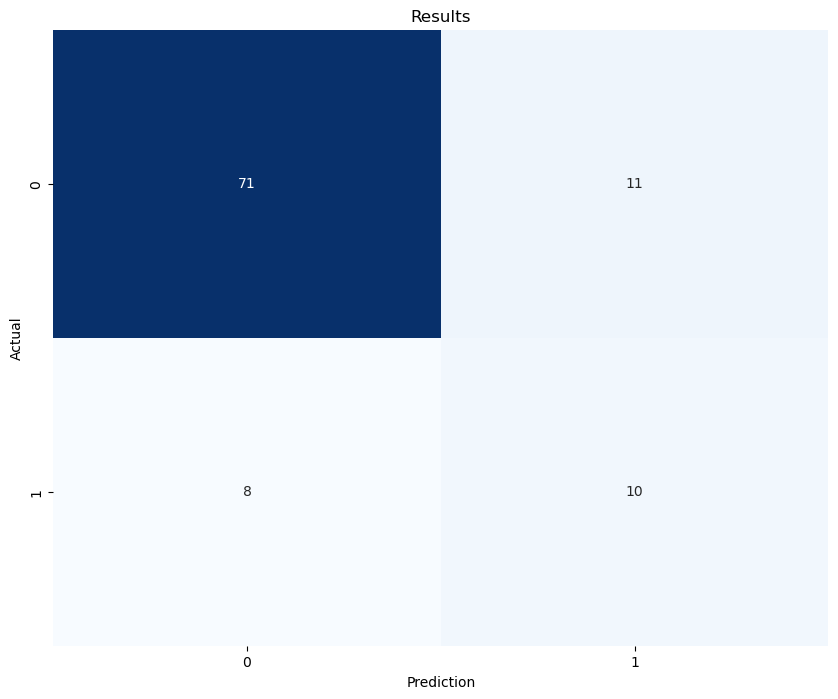

In [74]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy is {accuracy:.2f}")
print(f"F1 score is {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title("Results")

## Question c: Is `Average Pageviews` normally distributed? 